# Generative Adversarial Network using Keras
inspired by https://www.tensorflow.org/tutorials/generative/dcgan

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
from IPython import display


# Load and prepare dataset

In [53]:
import glob
from PIL import Image
image_list = []
for filename in glob.glob('./animeface_data/*.png'): 
    im=Image.open(filename)
    image_list.append(np.array(im))
    im.close()
train_images = np.array(image_list)
print(train_images.shape)


(8208, 256, 256, 3)


In [54]:
train_images = train_images.reshape(train_images.shape[0], 256, 256, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [55]:
BUFFER_SIZE = 60000
BATCH_SIZE = 32

In [56]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Network functions

# The Generator

In [64]:
def make_generator_model():
    inputs = layers.Input(shape=(100,))
    x = layers.Dense(8*8*256, use_bias=False, input_shape=(100,))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((8, 8, 256))(x)
    assert x.shape.as_list() == [None, 8, 8, 256] # Note: None is the batch size

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    assert x.shape.as_list() == [None, 8, 8, 128]
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    assert x.shape.as_list() == [None, 16, 16, 64]
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    assert x.shape.as_list() == [None, 32, 32, 32]
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    assert x.shape.as_list() == [None, 64, 64, 16]
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    assert x.shape.as_list() == [None, 128, 128, 8]
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    outputs = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    assert outputs.shape.as_list() == [None, 256, 256, 3]

    return keras.Model(inputs = inputs, outputs = outputs, name = "Generator_Network")

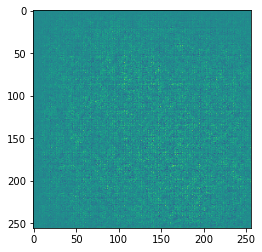

In [65]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

# The Discriminator

In [66]:
def make_discriminator_model():
    inputs = layers.Input(shape=(256,256,3))
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3])(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Flatten()(x)
    outputs = layers.Dense(1)(outputs)

    return keras.Model(inputs = inputs, outputs = outputs, name = "Discriminator_Network")

In [67]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00014626]], shape=(1, 1), dtype=float32)


# Loss and optimizer

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator Loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator Loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Learning rates

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Save Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training loop

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, True)

# Generate and save Images

In [ ]:
def generate_and_save_images(model, epoch, test_input, save=False):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  if(save):
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train the Model

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
train(train_dataset, EPOCHS)

# Restore latest checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))